## 07 Decision trees and ensembling

*special thanks to YSDA team for provided materials*`

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Short Recap: Decision Trees

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Plot decision surface

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [3]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  grid_step=0.02,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

### Toy multiclass data

In [4]:
#! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_f20/week0_07_boosting_feature_importances/data.npz

Let's try out a multiclass classification case.

Firstly, we'll load the data:

In [5]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


And then split it to train and test:

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

And let's have a look at the data.

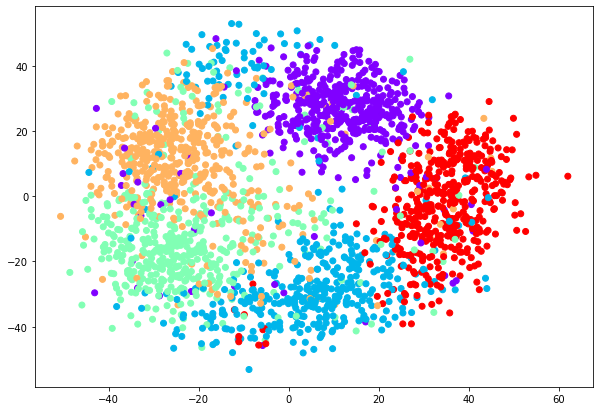

In [7]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rainbow')
plt.show()

Now that we've had a look at the data, let's fit a decision tree on it:

In [8]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

and plot the result:

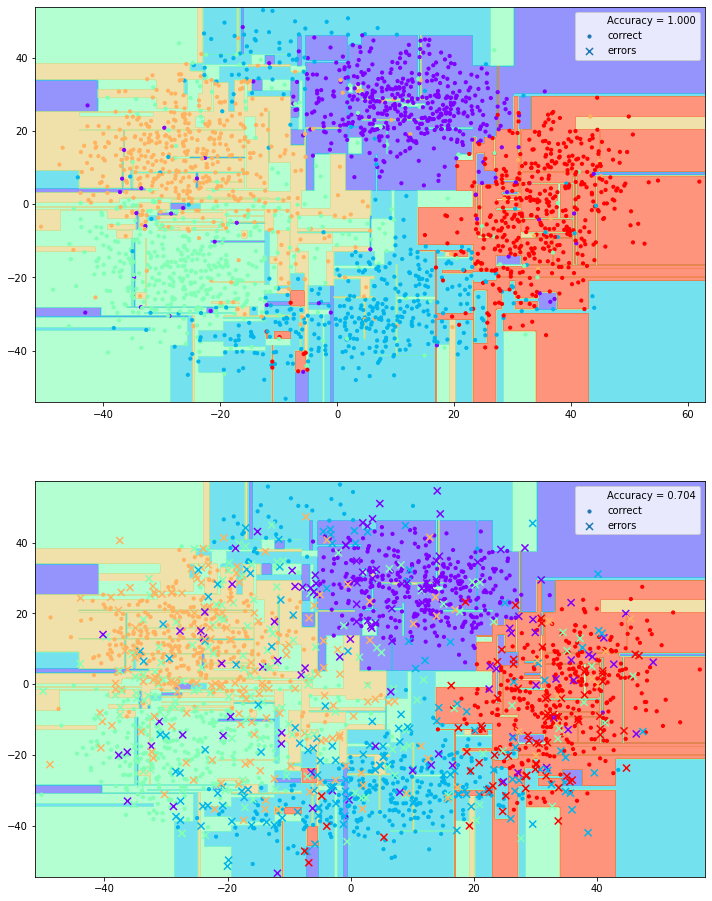

In [9]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow', grid_step=0.2)
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow', grid_step=0.2);

```

```

```

```

```

```

```

```

#### We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

**Note:** some of the parameters you can tune are under the "Decision trees out of the box" header.

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
params = {
    'max_depth': np.arange(2, 9),
    'min_samples_split': np.arange(2, 9),
    'min_samples_leaf': np.arange(1, 11),
    'min_impurity_decrease': np.linspace(0.0, 0.5, 5, dtype=np.float)   
}

In [17]:
grid_search = GridSearchCV(DecisionTreeClassifier(), params, scoring='accuracy', cv=5, refit=True)

In [18]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                         'min_impurity_decrease': array([0.   , 0.125, 0.25 , 0.375, 0.5  ]),
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8])},
             scoring='accuracy')

In [19]:
grid_search.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 3}

In [20]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=7, min_samples_split=3)

In [21]:
grid_search.best_score_

0.8117319536831733

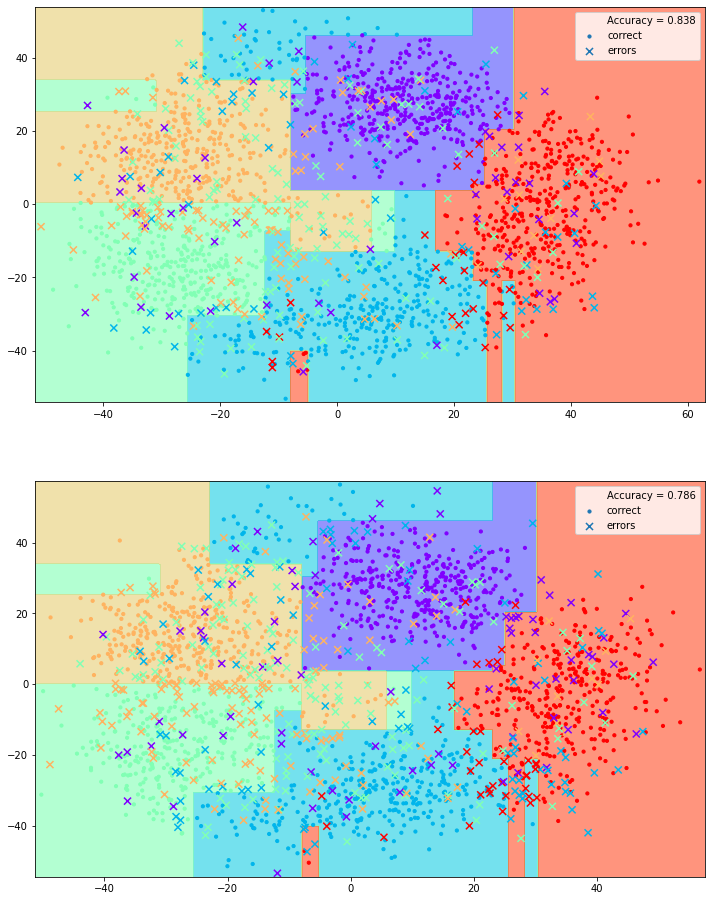

In [23]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(grid_search.best_estimator_, X_train, y_train, cmap='rainbow', grid_step=0.2)
plt.subplot(2, 1, 2)
plot_decision_surface(grid_search.best_estimator_, X_test, y_test, cmap='rainbow', grid_step=0.2);

#### Bonus quest
Try adding feature transformations using a pipeline and a function transformer, e.g.:
```python
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X, X**2], axis=1)),
    DecisionTreeClassifier()
)
```

Which transformations should improve the score?

```
```
```
```

We've talked a lot about the importance of feature scaling. Why aren't we doing it here?

Try adding a standard scaler to the pipeline of your best model and check how it affects the result. Can you explain the result?

In [ ]:
# <YOUR CODE>

```
```
```
```

## Ensembles

### Recap: Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

Let's use this model as a baseline ensemble approach.


## <font color=blue>Question: about scaling with LogReg and RF.</font>

- If we have categorical data it's a good idea to tranform it to numerical before applying a Logistic Regression model instead of Random Forest.
- Also it'll be a good idea to normalize the data before training with log reg.

With Random Forest (or Decision Trees) is not necessary to normalize the data, because on the one hand the tree divides the feature space according to some thresholds. On the other hand, normalization is a linear transformation, which can change the thresholds value, but not the way the feature space was divided.

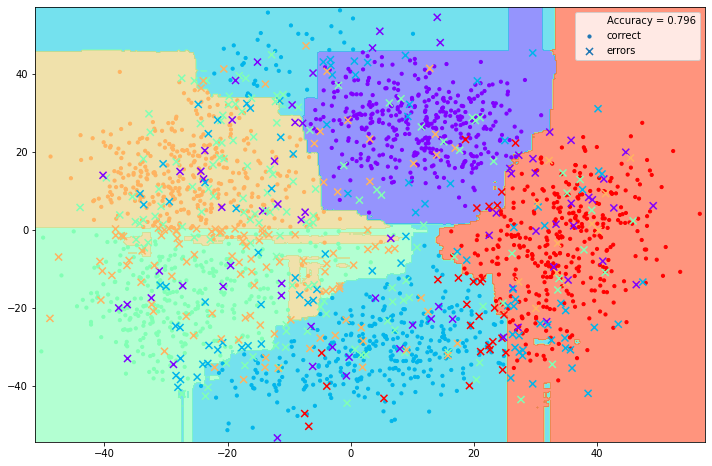

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with
# 100 estimators and at least 5 samples per leaf

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)

model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.2)

## <font color=blue>Question: Пробели</font>

- We see some division that shows clear signs of overfitting. If we increase `min_samples_leaf` these spaces start to disappear or start to increase.
    - Такие пробели появляются, потому что дерево пытается увеличить точность предсказывания.
    - They start to disappear, since by increasing the `min_samples_leaf` we tell the model to end up being more impure.
    
---

## <font color=blue>Question: Number of tree in RF</font>

Our training data has the following dimensions:

In [27]:
X_train.shape

(2252, 2)

We have 2 features. 

- How many trees does it make sense to use in this case?
    - With RF at each step for a tree we perform Random Feature Sampling. And by default: `max_features='auto'` which implies that `max_features=sqrt(n_features)`, but $\sqrt{2} = 1.414 \approx 1 \implies$ that at each step we select one feature at random. So each tree resembles an Extra Tree. We can't get more random than this (RFS is almost repeated every time). Therefore each new tree won't add new information but the one got from the different bootstrapped train set.


- Is it useful in this case (two dimensional data) to use RF?
    - It's useful from the point of view that can help us deal with the overfitting we got just by training one Decision Tree.

----

### Gradient Boosting

One of the most commonly used libraries for gradient boosting is the [XGBoost library](https://xgboost.ai/). Consider reading [this document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) for an introduction to the algorithm.

Here's the [help page](https://xgboost.readthedocs.io/en/latest/parameter.html) listing available parameters.

Let's start by importing the classifier class and the function that plots individual trees as graphs:

In [28]:
from xgboost import XGBClassifier, plot_tree

We can now investigate how decision surface depends on the number of trees:

n_estimators =  1


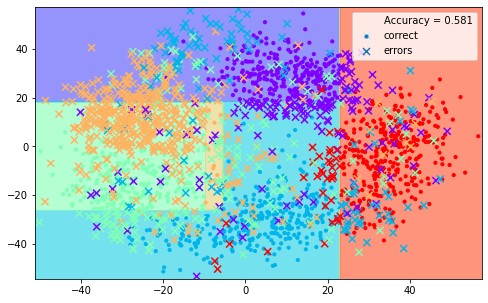

n_estimators =  2


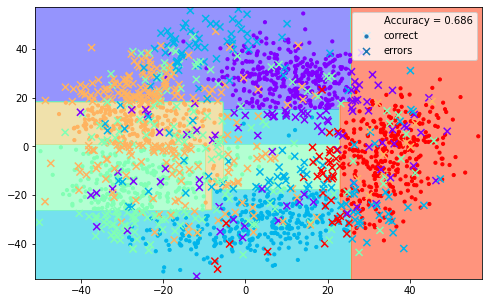

n_estimators =  3


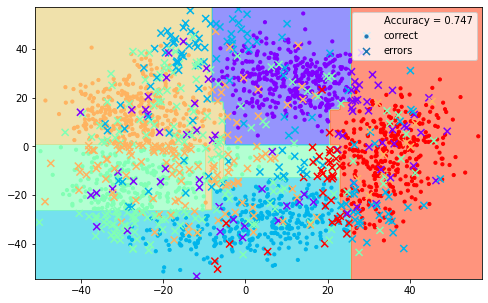

n_estimators =  4


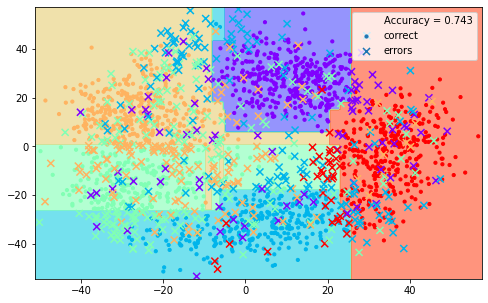

n_estimators =  5


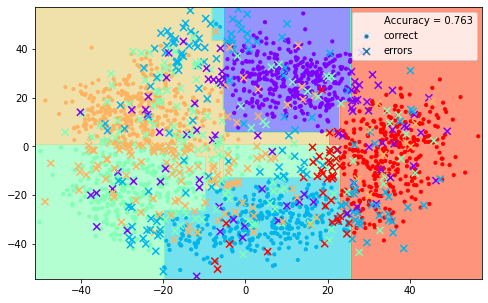

n_estimators =  6


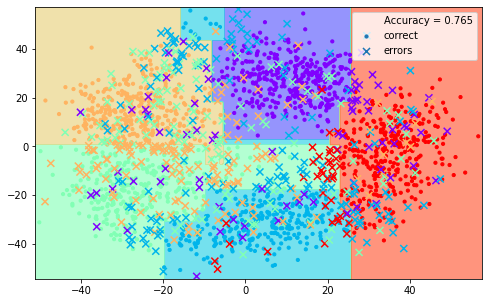

n_estimators =  7


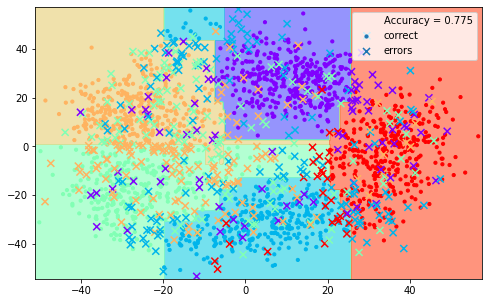

n_estimators =  8


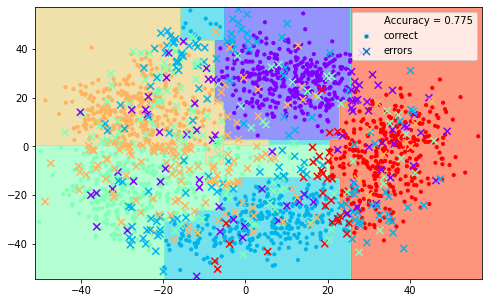

n_estimators =  9


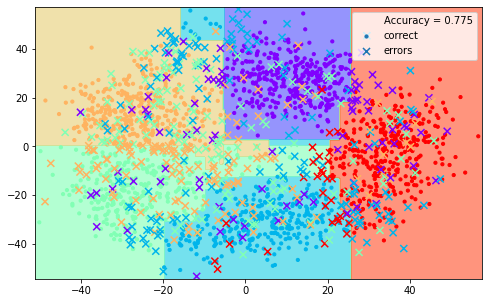

In [30]:
for n_estimators in range(1,10):
    # create an XGBClassifier with trees of depth 1
    # learning rate 0.5 and n_estimators estimators
    model = XGBClassifier(max_depth=1, learning_rate=0.5, n_estimators=n_estimators) 
    
    # fit this model to the train data
    model.fit(X_train, y_train)
    
    print("n_estimators = ", n_estimators)
    plt.figure(figsize=(8, 5))
    plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.4)
    plt.show()

And here's how one may use the `plot_tree` function:

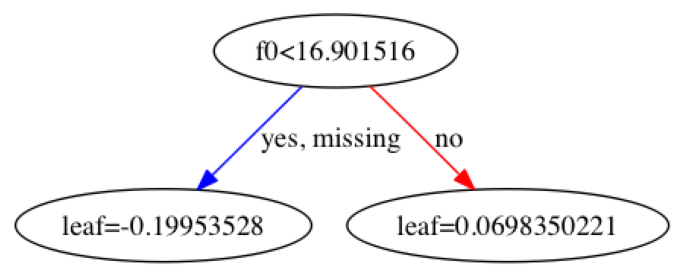

In [31]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_tree(model, num_trees=44, ax=ax, dpi='400');
#                   ^^^ This parameter selects the
#                       tree that you want to plot.
#                       Since there's 9 estimators
#                       in the last model and 5
#                       classes in our data, the total
#                       amount of individual trees
#                       is 45 (from 0 to 44).

<font color='red'>**Warning:**</font> current xgboost implementation is not very safe to typos, i.e. it can silently swallow whatever argument you provide, even if it has no effect, e.g.:

In [32]:
model = XGBClassifier(abrakadabra="I won't change anything")

so be sure to check your spelling.

Now let's try to improve the score by adjusting the parameters. Here are some of the parameters you may want to try:
  - `max_depth` – maximum tree depth,
  - `n_estimators` – number of trees (per class),
  - `learning_rate` – shrinkage,
  - `reg_lambda` – L2 regularization term on weights,
  - `subsample` – row random subsampling rate (per tree),
  - `colsample_bynode` – column subsampling rate (per node)
  - `gamma` – minimum loss reduction required to make a further partition on a leaf node of the tree

See [this page](https://xgboost.readthedocs.io/en/latest/parameter.html) for more information.

  > *Hint: since XGBClassifier has the same interface as sklearn models, you can use GridSearchCV on it if you want.* 

In [34]:
params = {
    'max_depth': np.arange(2, 9),
    'n_estimators': np.arange(5, 16),
    'learning_rate': np.linspace(0.0, 0.8, 10, dtype=np.float),
    'reg_lambda': np.linspace(0.0, 0.8, 5, dtype=np.float),
    'gamma': np.linspace(0.0, 0.5, 5, dtype=np.float)   
}

In [35]:
grid_search = GridSearchCV(XGBClassifier(), params, scoring='accuracy', cv=5, refit=True)

grid_search.fit(X_train, y_train)

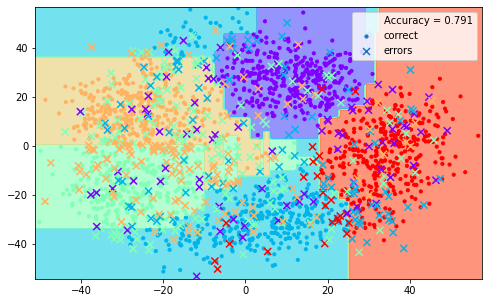

In [38]:
model = XGBClassifier(n_estimators=6, max_depth=3)
model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.8)
plt.show()

### Optional quest: AdaBoost from scratch

**Implement `Adaboost` class** (for classification taks)

**Details:**
- inherit class from `sklearn.BaseEstimator`;
- constructor must support the following parameters: 
    - `n_estimators` - the number of base models (decision stomps) for the ensemble;
    - `max_depth` - max depth for each decision tree (default - `None`);
- methods `fit` и `predict` must be implemented;
- method `fit` takes design matrix `X` and target vector `y` as inputs (`numpy.ndarray`) and returns `Adaboost` class, which is an ensemble of base estimators, trained using a dataset `(X, y)` given the parameters, passed to the constructor; 

In [41]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [66]:
from sklearn.base import BaseEstimator
class Adaboost(BaseEstimator):
    """
    Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses DecisionTreeClassifier. 
    
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    max_depth: int
        Maximal depth of the decision tree inside the ensemble
    """
    def __init__(self, n_estimators=5, max_depth=1, random_state=0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.alphas = []
        self.clfs = []
        self.random_state = random_state
        
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize all weights as 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        self.alphas = []
        
        _eps = 1e-10
        # Iterative fitting of the "weak" base estimators
        for _ in range(self.n_estimators):
            
            clf = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state) #<YOUR CODE HERE>
            clf.fit(X, y, sample_weight=w)
            
            predictions = clf.predict(X)
            min_error = sum(w[y != predictions]) #<YOUR CODE HERE>
            
            # Compute `alpha` parameter, which is used to update the weights of the samples from the training set
            # `alpha` may be considered as the  algorithm "performance" level approximation
            alpha = 0.5 * np.log((1. - min_error) / (min_error + _eps))#<YOUR CODE HERE>
            
            # Update the weights of the training set samples
            # Misclassified samples get larger weights, than those with correct class predictions
            #w *= np.exp(alpha[y != predictions])#<YOUR CODE HERE>
            w *= np.exp(-alpha * y * predictions)
            
            # Updated weights normalization
            w /= np.sum(w)
            
            # Save the base estimator and add its `alpha` parameter to the corresponding list
            self.clfs.append(clf)
            self.alphas.append(alpha)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        
        # Get the prediction from the every model, taking into account the corresponding `alpha` value
        for alpha, clf in zip(self.alphas, self.clfs):
            # Sum up the predictions weighted with the corresponding `alpha` values
            
            predictions = clf.predict(X).reshape(n_samples, 1)
            y_pred += alpha * predictions#<YOUR CODE HERE>

        # Class prediction is defined as the sign of weighted sum of the base estimator predictions
        y_pred = np.sign(y_pred).flatten()

        return y_pred

Load the toy dataset to evaluate the ensemble performance

In [67]:
from sklearn.datasets import load_digits

data = load_digits()
X = data.data
y = data.target

# select two different digits to construct the binary classification problem
digit1 = 1
digit2 = 8
idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
y = data.target[idx]

# Change class labels to -1 and 1
y[y == digit1] = -1
y[y == digit2] = 1
X = data.data[idx]

# split the dataset into training and testing sets
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.5, random_state=42)

Set up AdaBoost hyperparameters

In [68]:
# set base estimator number
n_estimators = 12
max_depth = 1

# set up base estimator
base_clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
base_clf.fit(train_X, train_Y)

# save base estimator performance for future comparison
y_pred_base = base_clf.predict(test_X)
print ("Decision Stump accuracy: {:.5f}".format(accuracy_score(test_Y, y_pred_base)))

Decision Stump accuracy: 0.77528


Let's create a reference model using scikit-learn version of AdaBoostClassifier:

In [69]:
from sklearn.ensemble import AdaBoostClassifier

# use scikit-learn version as a reference
ada = AdaBoostClassifier(
    base_estimator=base_clf,
    n_estimators=n_estimators,
    random_state=43,
    algorithm='SAMME')

ada.fit(train_X, train_Y)
y_pred_ada = ada.predict(test_X)

sklearn_accuracy = accuracy_score(test_Y, y_pred_ada)
print ("Scikit-learn' AdaBoost with {} estimators accuracy: {:.5f}".format(n_estimators, sklearn_accuracy))

Scikit-learn' AdaBoost with 12 estimators accuracy: 0.91011


And here we are finally using our own class:

In [70]:
n_estimators, max_depth

(12, 1)

In [71]:
clf = Adaboost(n_estimators=n_estimators, max_depth=max_depth, random_state=32)
clf.fit(train_X, train_Y)

y_pred = clf.predict(test_X)
my_accuracy = accuracy_score(test_Y, y_pred)

assert np.allclose(my_accuracy, sklearn_accuracy), 'Your implementation accuracy does not match the sklearn version'
print ("My AdaBoost implementation with {} estimators accuracy: {:.5f}".format(n_estimators, my_accuracy))

My AdaBoost implementation with 12 estimators accuracy: 0.91011


```
```
```
```

```
```
```
```

```
```
```
```